# Reservoir model - only output is trained - evolutionary optimization

- Implemented a recurrent reservoir model, see summary(model) below for details on the layers. 
- Performing classification on the Digits dataset and MNIST dataset
- Results measured in logg loss (sum) and accuracy. 


In [86]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import load_digits
from sklearn import datasets
import numpy as np
import os, sys, tarfile
import requests
import shutil
import torchvision
import numpy as np
from PIL import Image
from torchvision import transforms
from torch.utils.data import random_split
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import random
from pytorch_model_summary import summary
import copy

### The Digits Dataset:

In [87]:
class Digits(Dataset):
    """Scikit-Learn Digits dataset."""

    def __init__(self, mode='train', transforms=None):
        digits = load_digits()
        if mode == 'train':
            self.data = digits.data[:1000].astype(np.float32)
            self.targets = digits.target[:1000]
        elif mode == 'val':
            self.data = digits.data[1000:1350].astype(np.float32)
            self.targets = digits.target[1000:1350]
        else:
            self.data = digits.data[1350:].astype(np.float32)
            self.targets = digits.target[1350:]
        self.transforms = transforms
        self.target_names = digits.target_names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [88]:
# Initiliazing the data loaders for the digits dataset. 

train_data_digits = Digits(mode='train')
val_data_digits = Digits(mode='val')
test_data_digits = Digits(mode='test')

LABELS = train_data_digits.target_names

train_loader_digits = DataLoader(train_data_digits, batch_size=50, shuffle=True)
val_loader_digits = DataLoader(val_data_digits, batch_size=50, shuffle=False)
test_loader_digits = DataLoader(test_data_digits, batch_size=50, shuffle=False)

result_dir = 'results_reservoir_evolution_wiebe/'
if not(os.path.exists(result_dir)):
    os.mkdir(result_dir)

6


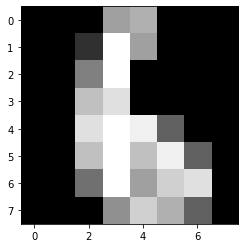

In [89]:
# Print an example digit and its according target label. - (digits dataset)

print(train_data_digits.targets[88])
plottable_image = np.reshape(train_data_digits.data[88], (8, 8))
plt.imshow(plottable_image, cmap='gray')

### The MNIST Dataset:

In [90]:
class MNIST(Dataset):
    """Complete MNIST dataset."""

    def __init__(self, mode='train', transforms=None):
        data_set_train = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))

        data_set_test = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ]))
        self.data = []
        self.targets = []
        
        if mode == 'train':
            for i in range(40000):
                self.data.append(data_set_train[i][0].numpy())
                self.targets.append(data_set_train[i][1])
        elif mode == 'val':
            for i in range(50000, 60000):
                self.data.append(data_set_train[i][0].numpy())
                self.targets.append(data_set_train[i][1])
        else:
            for i in range(len(data_set_test)):
                self.data.append(data_set_test[i][0].numpy())
                self.targets.append(data_set_test[i][1])
        
        self.targets = np.array(self.targets)
        self.data = np.array(self.data)
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample_x = self.data[idx]
        sample_y = self.targets[idx]
        if self.transforms:
            sample_x = self.transforms(sample_x)
        return (sample_x, sample_y)

In [91]:
# Load in the MNIST dataset - (takes longer to load than Digits!, 6)
train_data_mnist = MNIST(mode='train')
val_data_mnist = MNIST(mode='val')
test_data_mnist = MNIST(mode='test')

train_loader_mnist = DataLoader(train_data_mnist, batch_size=50, shuffle=True)
val_loader_mnist = DataLoader(val_data_mnist, batch_size=50, shuffle=True)
test_loader_mnist = DataLoader(test_data_mnist, batch_size=50, shuffle=True)

1


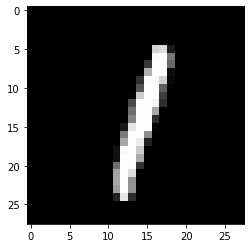

In [92]:
# Print an example MNIST digit and its according target label. - (digits dataset)

print(val_data_mnist.targets[1900])
plottable_image = np.reshape(val_data_mnist.data[1900], (28, 28))
plt.imshow(plottable_image, cmap='gray')

In [93]:
class Reservoir(nn.Module):
    def __init__(self, input_size, reservoir_size, output_size, T, dataset = None):
        super(Reservoir, self).__init__()
        
        # Activation functions
        self.f_0 = nn.Tanh()
        self.f_t = nn.ReLU(inplace=False)
        self.f_y = nn.LogSoftmax(dim=1)
        
        # Amount of timesteps / recurrent layers
        self.T = T
        
        # Initialize the weights & layers
        self.initWeights(input_size, reservoir_size, output_size)
        self.initLayers(input_size, reservoir_size, output_size)
        
        # Boolean
        self.dataset = dataset

    def forward(self, input):
        
        used_input = input
        
        # Squeeze the used input in 2 dims if we use the MNIST dataset.
        if self.dataset == 'MNIST':
            three_d_tensor = used_input.squeeze(1)
            used_input = three_d_tensor.contiguous().view(three_d_tensor.size()[0], -1)  # 28 * 28 pixels = 784
        
        # Calculate c_0
        c = self.f_0(self.layer1(used_input))
        
        for t in range(self.T):
            # c_t =  f_t (W_r * c_t-1 + U * x_t)
            c = self.f_t(self.layer2(c) + self.layer3(used_input))
        
        # Calculate y = f_y ( W_out * c_t)
        y = self.f_y(self.layer4(c))
    
        return y
    
    def initWeights(self, input_size, reservoir_size, output_size):
        
        # Sample the initial weights from a uniform distribution - initialize the same as in the baseline model.
        self.W_in = nn.Parameter(data = torch.zeros(reservoir_size, input_size, requires_grad=False))
        self.W_in.data.uniform_(-0.01, 0.01)
        
        self.W_r = nn.Parameter(data = torch.zeros(reservoir_size, reservoir_size), requires_grad=False)
        self.W_r.data.uniform_(-0.01, 0.01)
        
        self.W_out = nn.Parameter(data = torch.zeros(output_size, reservoir_size), requires_grad=True)
        self.W_out.data.uniform_(-0.01, 0.01)
        
        self.U = nn.Parameter(data = torch.zeros(reservoir_size, input_size), requires_grad=False)
        self.U.data.uniform_(-0.01, 0.01)
        return
    
    def initLayers(self, input_size, reservoir_size, output_size):
        # Input layer
        self.layer1 = torch.nn.Linear(input_size, reservoir_size, bias=True)
        self.layer1.weight = self.W_in
        self.layer1.weight.requires_grad = False
        self.layer1.bias.requires_grad = False
        
        # Recurrent layer
        self.layer2 = torch.nn.Linear(reservoir_size, reservoir_size, bias=True)
        self.layer2.weight = self.W_r
        self.layer2.bias.requires_grad = False
        self.layer3 = torch.nn.Linear(input_size, reservoir_size, bias=True)
        self.layer3.weight = self.U
        self.layer3.bias.requires_grad = False
        
        # Output layer
        self.layer4 = torch.nn.Linear(reservoir_size, output_size, bias=True)
        self.layer4.weight = self.W_out
        self.layer4.bias.requires_grad = True
        return
        

In [118]:
# Function that transforms the tensor output to a predicted target name. 
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i]
    
def plot_results(epochs_list, loss_list, accuracy_list, border, title):
    fig, (ax1, ax2) = plt.subplots(2)
    fig.suptitle('%s' %(title))
    ax1.set(ylabel='Loss')
    ax2.set(ylabel='Accuracy', xlabel='Epochs')
    
    epoch_loss = zip(epochs_list, loss_list)
    epoch_accuracy = zip(epochs_list, accuracy_list)
    
    for epochs, loss in epoch_loss:
        ax1.plot(epochs, loss, color='b')
    
    for epochs, accuracy in epoch_accuracy:
        ax2.plot(epochs, accuracy, color='b')
    
    ax1.axvline(border, color='r', label='backprop end')
    ax1.legend(loc='upper right')
    ax2.axvline(border, color='r',label='backprop end')
    ax2.legend(loc='lower right')

    plt.savefig('%s.png' %(title), bbox_inches='tight')
    #plt.close()
    return

def plot_population(best_pop, population_size, mutate_opt, select_opt, dataset):
    epochs_d = []
    loss_results_d = []
    accuracy_results_d = []

    for model in best_pop_digits:
        epochs_d.append(model['epoch'])
        loss_results_d.append(model['loss_results'])
        accuracy_results_d.append(model['accuracy_results'])

    plot_results(epochs_d, 
                    loss_results_d , 
                    accuracy_results_d, 
                    n_epochs,
                    '%s - Pop size %s - Mut %s - Select %s ' %(dataset, population_size, mutate_opt, select_opt))
    return


# Concatenating the results of all (64*)batches in the lists, calculating the total accuracy. 
def accuracy(pred_targets_list, gold_targets_list):
    total_correct = 0
    total_amount = 0
    
    zip_list = zip(pred_targets_list, gold_targets_list)
    for pred_targets, gold_targets in zip_list:
        total_correct += (pred_targets == gold_targets).float().sum()
        total_amount += len(pred_targets)
    
    accuracy = 100 * total_correct / total_amount

    return accuracy.item()

# Evaluation -> used for validation and test set. 
def evaluation(val_loader, model, epoch, loss_function):
    
    #Evaluating our performance so far
    model.eval()
    
    # Store all results in a list to calculate the accuracy. 
    pred_target_total_acc = []
    target_total_acc = []
    
    # Initialize counters / c
    loss = 0.
    N = 0.
    
    # Iterating over the validation set batches, acquiring tensor formatted results. 
    for indx_batch, (batch, targets) in enumerate(val_loader):
        output = model.forward(batch)
        pred_targets = np.array([])
        for item in output:
            pred_targets = np.append(pred_targets, categoryFromOutput(item))
        pred_targets = torch.from_numpy(pred_targets).int()
        
        # Calculating loss
        loss_t = loss_function(output, targets.long())
        loss = loss + loss_t.item()
        N = N + batch.shape[0]
        
        #Append the batch result to a list of all results
        pred_target_total_acc.append(pred_targets)
        target_total_acc.append(targets)
    
    # Store the loss corrected by its size
    loss = loss / N   
        
    total_accuracy = accuracy(pred_target_total_acc, target_total_acc)
    print('Epoch: %s - Loss of: %s - Accuracy of: %s' %(epoch, loss,total_accuracy))
    
    return epoch, loss, total_accuracy

In [95]:
def training(model, train_loader, val_loader, num_epochs, optimizer, loss_function, max_loss_iter):    
    
    print('Training started for %s epochs.'  %(num_epochs))
    epochs = []
    accuracy_results = []
    loss_results = []
    best_loss = 10000 # Picking random high number to assure correct functionality
    loss_iter = 0

    torch.autograd.set_detect_anomaly(True)

    for epoch in range(num_epochs):

        # Training
        model.train()
        for indx_batch, (batch, targets) in enumerate(train_loader):

            output = model.forward(batch)

            targets = targets.long()

            loss = loss_function(output, targets)
            
            # Optional print of loss per batch
            #print('Loss in batch %s is: %s' %(indx_batch, loss))
        
            # Perform back prop after each batch
            loss = loss_function(output, targets)
            optimizer.zero_grad()
            loss.backward(retain_graph = True)
            optimizer.step()

        # Perform evaluation after each epoch
        epoch, loss_eval, accuracy_eval = evaluation(val_loader, model, epoch, loss_function)
        epochs.append(epoch)
        accuracy_results.append(accuracy_eval)
        loss_results.append(loss_eval)

        '''if epoch == 0:
            print('* Saving 1st epoch model *')
            torch.save(model, 'trained_reservoir.model')
            best_loss = loss_eval
        else:
            if loss_eval < best_loss:
                print('* Saving new best model *')
                torch.save(model, 'trained_reservoir.model')
                best_loss = loss_eval
                loss_iter = 0
            else:
                loss_iter += 1

            # If loss has not improved for an arbitrary amount of epochs: '''
        if loss_iter > max_loss_iter:
            break

    dict_results = {
        'model': model,
        'epoch': epochs,
        'loss_results': loss_results,
        'accuracy_results':accuracy_results,
        'best_loss': best_loss,
        'loss_iter': loss_iter,
    }
    
    #plot_results(epochs, loss_results, accuracy_results)
    
    return dict_results

    

In [117]:
input_size_digits = 64  # 8 * 8 pixels
input_size_mnist = 784  # 28 * 28 pixels
reservoir_size = 128
n_labels = 10
lr_SGD = 0.0001
momentum_SGD = 0.9
n_epochs = 5 # with backprop
max_loss_iter = 10
batch_size= 50
T = 5

population_size = 20
generations = 50
mutate_opt = 'random_perturbation'
select_opt = 'accuracy'

In [111]:
class EA(object):
    def __init__(self,  population_size, val_loader, loss_function, input_size, reservoir_size, n_labels):
        self.population_size = population_size
        self.val_loader = val_loader
        self.loss_function = loss_function
        self.input_size = input_size
        self.reservoir_size = reservoir_size
        self.output_size = n_labels

    def fitness(self, population, parents=None):
        
        # Copy paste the last results, so we don't have to calculate the loss and accuracy of an unchanged model. 
        if parents == True:
            for reservoir in population:
                reservoir['epoch'].append(reservoir['epoch'][-1]+1)
                reservoir['loss_results'].append(reservoir['loss_results'][-1])
                reservoir['accuracy_results'].append(reservoir['accuracy_results'][-1])
            
        else:
            # Evaluate the performance of every (mutated/recombinated) model in the population,
            # add the results to results list. 
            for reservoir in population:
                epoch, loss, total_accuracy = evaluation(self.val_loader, 
                                                         reservoir['model'], 
                                                         reservoir['epoch'][-1]+1, 
                                                         loss_function)
                reservoir['epoch'].append(epoch)
                reservoir['loss_results'].append(loss)
                reservoir['accuracy_results'].append(total_accuracy)

                # If we find a new best model, save it.
                # Still have to fine tune this , make a directory for all the models. 
                '''if loss < reservoir['best_loss']:
                    print('* Saving new best model *')
                    torch.save(reservoir['model'], 'trained_reservoir.model')
                    reservoir['best_loss'] = loss
                    reservoir['loss_iter'] = 0
                else:
                    reservoir['loss_iter'] += 1'''

        return population

    def mutation(self, pop, option):
        
        if option == 'random_perturbation':
            pop, mut_pop = self.random_perturbation(pop, distribution='gaussian')
        
        elif option == 'diff_mutation':
            perturb_rate = 2
            pop, mut_pop = self.diff_mutation(pop, perturb_rate)
        
        return pop, mut_pop 
    
    def diff_mutation(self, pop, perturb_rate):
        mut_pop = copy.deepcopy(pop)
        
        for reservoir in mut_pop:
            
            #Changed name to make more readable
            model = reservoir['model']
            
            # Randomly sample 2 models from the population & split them up
            sample = random.sample(pop, 2)
            sample1 = sample[0]['model']
            sample2 = sample[1]['model']
            
            # Perturb the weights
            model.W_in +=  perturb_rate * (sample1.W_in - sample2.W_in)
            model.W_r += perturb_rate * (sample1.W_r - sample2.W_r)
            model.U += perturb_rate * (sample1.U - sample2.U)
            temp_w_out = model.W_out + perturb_rate * (sample1.W_out - sample2.W_out)
            model.W_out = nn.Parameter(temp_w_out, requires_grad = False)
        
        return pop, mut_pop
    
    def random_perturbation(self, pop, distribution=None):
        mut_pop = copy.deepcopy(pop)
        
        # Using a uniform distribution to sample from
        if distribution == 'uniform':
            W_in_sample = torch.empty(self.reservoir_size, self.input_size).uniform_(-0.005, 0.005)
            W_r_sample = torch.empty(self.reservoir_size, self.reservoir_size).uniform_(-0.005, 0.005)
            W_out_sample = torch.empty(self.output_size, self.reservoir_size).uniform_(-0.005, 0.005)
            U_sample = torch.empty(self.reservoir_size, self.input_size).uniform_(-0.005, 0.005)
        
        # Using a normal distribution to sample from
        elif distribution == 'gaussian':
            W_in_sample = torch.empty(self.reservoir_size, self.input_size).normal_(0, 0.0025)
            W_r_sample = torch.empty(self.reservoir_size, self.reservoir_size).normal_(0, 0.0025)
            W_out_sample = torch.empty(self.output_size, self.reservoir_size).normal_(0, 0.0025)
            U_sample = torch.empty(self.reservoir_size, self.input_size).normal_(0, 0.0025)
        
        for reservoir in mut_pop:
            reservoir['model'].W_in += W_in_sample
            reservoir['model'].W_r += W_r_sample
            reservoir['model'].U += U_sample
            
            # We have to turn off requires grad,
            # because pytorch does not allow inplace mutations on tensors which are used for backprop.
            # See https://discuss.pytorch.org/t/leaf-variable-was-used-in-an-inplace-operation/308/2 .
            reservoir['model'].W_out.requires_grad = False
            reservoir['model'].W_out += W_out_sample
        
        return pop, mut_pop

    def recombination(self, pop):  # Idea: swapp the weight matrices among the population
        mut_pop = copy.deepcopy(pop)
        
        # Last model is not changed
        for reservoir in mut_pop:
            pass
        
        return mut_pop 

    def selection(self, pop, mut_pop, option):
        
        # Merge parents and childs
        total_pop = pop + mut_pop
        
        # Select the top performing (lowest loss)
        if option == 'loss':
            total_pop = sorted(total_pop, key=lambda k: k['loss_results'][-1]) 
            new_pop = total_pop[:len(pop)]
            
        # Select the top performing (highest accuracy)
        elif option == 'accuracy':
            total_pop = sorted(total_pop, key=lambda k: k['accuracy_results'][-1], reverse=True) 
            new_pop = total_pop[:len(pop)]
            
        
        return new_pop
    
    def step(self, pop, mutate_opt, select_opt):
        pop, mut_pop = self.mutation(pop, mutate_opt)
        
        # Fitness from non-mutated are the top validation results from previous iteration. 
        pop = self.fitness(pop, parents=True)
        
        # Fitness from mutated population are calculated 
        print('Mutation') 
        mut_pop = self.fitness(mut_pop, parents=False)
        
        #self.recombination(childs)
        
        new_pop = self.selection(pop, mut_pop, select_opt)
        
        return new_pop



### Training and analysing the perfomance on Digits

In [112]:
# Initialize population - train by backprop for a few epochs. 
model_set_digits = []

for i in range(population_size):
    model_digits = Reservoir(input_size_digits, reservoir_size, n_labels, T, dataset = 'Digits')
    optimizer_digits = optim.SGD([p for p in model_digits.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
    loss_function = nn.NLLLoss(reduction='sum') # Mean is also possible.
    trained_model_digits = training(model_digits, train_loader_digits, val_loader_digits, n_epochs, optimizer_digits, loss_function, max_loss_iter)
    model_set_digits.append(trained_model_digits)

# Retrieve the best model after the backprop epochs - no evolution has taken place yet. 
best_backprop_acc = sorted(model_set_digits, key=lambda k: k['accuracy_results'][-1] , reverse=True) 
best_backprop_loss = sorted(model_set_digits, key=lambda k: k['loss_results'][-1] , reverse=False) 

Training started for 5 epochs.
Epoch: 0 - Loss of: 2.255469927106585 - Accuracy of: 16.571428298950195
Epoch: 1 - Loss of: 2.1842469351632254 - Accuracy of: 62.57143020629883
Epoch: 2 - Loss of: 2.1136761256626673 - Accuracy of: 64.0
Epoch: 3 - Loss of: 2.046318577357701 - Accuracy of: 68.85713958740234
Epoch: 4 - Loss of: 1.981703360421317 - Accuracy of: 77.71428680419922
Training started for 5 epochs.
Epoch: 0 - Loss of: 2.2546974182128907 - Accuracy of: 57.42856979370117
Epoch: 1 - Loss of: 2.1759239196777345 - Accuracy of: 78.28571319580078
Epoch: 2 - Loss of: 2.0983768354143417 - Accuracy of: 83.71428680419922
Epoch: 3 - Loss of: 2.0238369532993863 - Accuracy of: 86.57142639160156
Epoch: 4 - Loss of: 1.9528663635253907 - Accuracy of: 89.14286041259766
Training started for 5 epochs.
Epoch: 0 - Loss of: 2.2575920976911275 - Accuracy of: 54.28571319580078
Epoch: 1 - Loss of: 2.1860630580357143 - Accuracy of: 73.14286041259766
Epoch: 2 - Loss of: 2.1147391836983815 - Accuracy of: 72.5

### Possible settings:
mutate_opt = 'diff_mutation'

mutate_opt = 'random_perturbation'

select_opt = 'loss'

select_opt = 'accuracy'

In [113]:
ea = EA(population_size, val_loader_digits, loss_function, input_size_digits, reservoir_size, n_labels)   

# Initialize the population
new_pop = model_set_digits

# Perform ea steps
for i in range(generations):
    new_pop = ea.step(new_pop, mutate_opt, select_opt)

# Get the best performing population after x amount of generations, based on accuracy or loss
if select_opt == 'accuracy':
    best_pop_digits = sorted(new_pop, key=lambda k: k['accuracy_results'][-1] , reverse=True) 
elif select_opt == 'loss':
    best_pop_digits = sorted(new_pop, key=lambda k: k['loss_results'][-1] , reverse=False)


Mutation
Epoch: 5 - Loss of: 2.0020361110142297 - Accuracy of: 70.85713958740234
Epoch: 5 - Loss of: 1.9805446079799107 - Accuracy of: 85.14286041259766
Epoch: 5 - Loss of: 1.9963873726981027 - Accuracy of: 85.14286041259766
Epoch: 5 - Loss of: 1.9944543021065848 - Accuracy of: 78.57142639160156
Epoch: 5 - Loss of: 1.9770646449497769 - Accuracy of: 82.57142639160156
Epoch: 5 - Loss of: 1.9780496215820313 - Accuracy of: 75.42857360839844
Epoch: 5 - Loss of: 2.010145481654576 - Accuracy of: 76.57142639160156
Epoch: 5 - Loss of: 1.980293208530971 - Accuracy of: 78.57142639160156
Epoch: 5 - Loss of: 1.9111042567661831 - Accuracy of: 82.0
Epoch: 5 - Loss of: 1.9643319266183035 - Accuracy of: 85.42857360839844
Epoch: 5 - Loss of: 1.9556494576590402 - Accuracy of: 69.42857360839844
Epoch: 5 - Loss of: 1.9768154471261161 - Accuracy of: 76.0
Epoch: 5 - Loss of: 1.9216339547293526 - Accuracy of: 81.71428680419922
Epoch: 5 - Loss of: 1.9842802211216517 - Accuracy of: 78.28571319580078
Epoch: 5 - 

Epoch: 10 - Loss of: 1.9443647112165179 - Accuracy of: 77.42857360839844
Epoch: 10 - Loss of: 1.9448172433035715 - Accuracy of: 82.57142639160156
Epoch: 10 - Loss of: 1.9437819126674107 - Accuracy of: 75.14286041259766
Epoch: 10 - Loss of: 1.9437328229631696 - Accuracy of: 75.14286041259766
Mutation
Epoch: 11 - Loss of: 1.9120017569405692 - Accuracy of: 84.28571319580078
Epoch: 11 - Loss of: 1.926741485595703 - Accuracy of: 71.42857360839844
Epoch: 11 - Loss of: 1.9161776515415736 - Accuracy of: 84.0
Epoch: 11 - Loss of: 1.9251534380231585 - Accuracy of: 72.28571319580078
Epoch: 11 - Loss of: 1.9197403826032367 - Accuracy of: 76.28571319580078
Epoch: 11 - Loss of: 1.924162815638951 - Accuracy of: 81.71428680419922
Epoch: 11 - Loss of: 1.923330579485212 - Accuracy of: 69.71428680419922
Epoch: 11 - Loss of: 1.9373440333775112 - Accuracy of: 74.0
Epoch: 11 - Loss of: 1.925292271205357 - Accuracy of: 72.28571319580078
Epoch: 11 - Loss of: 1.9330557250976563 - Accuracy of: 68.28571319580078

Epoch: 16 - Loss of: 1.904882332938058 - Accuracy of: 75.42857360839844
Epoch: 16 - Loss of: 1.907122323172433 - Accuracy of: 83.71428680419922
Epoch: 16 - Loss of: 1.911551295689174 - Accuracy of: 76.85713958740234
Epoch: 16 - Loss of: 1.9050933183942522 - Accuracy of: 78.85713958740234
Epoch: 16 - Loss of: 1.90953125 - Accuracy of: 69.71428680419922
Epoch: 16 - Loss of: 1.9040078517368861 - Accuracy of: 74.85713958740234
Epoch: 16 - Loss of: 1.9085874720982143 - Accuracy of: 75.14286041259766
Epoch: 16 - Loss of: 1.9087014552525112 - Accuracy of: 80.85713958740234
Epoch: 16 - Loss of: 1.9178396606445312 - Accuracy of: 77.71428680419922
Mutation
Epoch: 17 - Loss of: 1.9201669529506138 - Accuracy of: 80.28571319580078
Epoch: 17 - Loss of: 1.9197050258091517 - Accuracy of: 82.85713958740234
Epoch: 17 - Loss of: 1.9043760027204242 - Accuracy of: 75.42857360839844
Epoch: 17 - Loss of: 1.9013780430385046 - Accuracy of: 78.28571319580078
Epoch: 17 - Loss of: 1.9084166826520648 - Accuracy of

Epoch: 22 - Loss of: 1.8956183297293527 - Accuracy of: 72.85713958740234
Epoch: 22 - Loss of: 1.892231968470982 - Accuracy of: 78.0
Epoch: 22 - Loss of: 1.9145053972516741 - Accuracy of: 82.0
Epoch: 22 - Loss of: 1.8913284737723215 - Accuracy of: 75.71428680419922
Epoch: 22 - Loss of: 1.896245836530413 - Accuracy of: 72.28571319580078
Epoch: 22 - Loss of: 1.8982967267717634 - Accuracy of: 74.28571319580078
Epoch: 22 - Loss of: 1.8997278703962053 - Accuracy of: 68.85713958740234
Epoch: 22 - Loss of: 1.8942174203055246 - Accuracy of: 70.57142639160156
Epoch: 22 - Loss of: 1.8949820818219867 - Accuracy of: 62.57143020629883
Epoch: 22 - Loss of: 1.8935519191196986 - Accuracy of: 70.28571319580078
Epoch: 22 - Loss of: 1.8997570582798549 - Accuracy of: 73.71428680419922
Epoch: 22 - Loss of: 1.8981039428710937 - Accuracy of: 65.71428680419922
Epoch: 22 - Loss of: 1.8957657732282367 - Accuracy of: 64.0
Epoch: 22 - Loss of: 1.9067867824009486 - Accuracy of: 80.57142639160156
Mutation
Epoch: 23 

Epoch: 28 - Loss of: 1.8794105311802456 - Accuracy of: 68.0
Epoch: 28 - Loss of: 1.8835587637765068 - Accuracy of: 69.14286041259766
Epoch: 28 - Loss of: 1.890781991141183 - Accuracy of: 74.85713958740234
Epoch: 28 - Loss of: 1.8868940734863282 - Accuracy of: 71.71428680419922
Epoch: 28 - Loss of: 1.890363529750279 - Accuracy of: 71.42857360839844
Epoch: 28 - Loss of: 1.8851568821498326 - Accuracy of: 67.42857360839844
Epoch: 28 - Loss of: 1.8908103724888392 - Accuracy of: 72.85713958740234
Epoch: 28 - Loss of: 1.8865408543178013 - Accuracy of: 74.85713958740234
Epoch: 28 - Loss of: 1.8856006949288504 - Accuracy of: 70.0
Epoch: 28 - Loss of: 1.8913125828334263 - Accuracy of: 68.85713958740234
Epoch: 28 - Loss of: 1.8930279105050223 - Accuracy of: 77.71428680419922
Epoch: 28 - Loss of: 1.8946205139160157 - Accuracy of: 76.0
Epoch: 28 - Loss of: 1.8978487941196986 - Accuracy of: 74.85713958740234
Epoch: 28 - Loss of: 1.894482661655971 - Accuracy of: 76.0
Epoch: 28 - Loss of: 1.8895978219

Epoch: 33 - Loss of: 1.8906307547433037 - Accuracy of: 69.42857360839844
Epoch: 33 - Loss of: 1.8830714416503906 - Accuracy of: 67.71428680419922
Mutation
Epoch: 34 - Loss of: 1.8745684378487724 - Accuracy of: 74.0
Epoch: 34 - Loss of: 1.8786068289620537 - Accuracy of: 73.14286041259766
Epoch: 34 - Loss of: 1.8773458426339287 - Accuracy of: 74.28571319580078
Epoch: 34 - Loss of: 1.8783875165666852 - Accuracy of: 75.14286041259766
Epoch: 34 - Loss of: 1.8816646030970983 - Accuracy of: 72.28571319580078
Epoch: 34 - Loss of: 1.8766871207101004 - Accuracy of: 76.0
Epoch: 34 - Loss of: 1.8794568961007254 - Accuracy of: 74.28571319580078
Epoch: 34 - Loss of: 1.8804773385184153 - Accuracy of: 73.42857360839844
Epoch: 34 - Loss of: 1.8805017743791852 - Accuracy of: 70.85713958740234
Epoch: 34 - Loss of: 1.880267072405134 - Accuracy of: 67.14286041259766
Epoch: 34 - Loss of: 1.882633819580078 - Accuracy of: 70.57142639160156
Epoch: 34 - Loss of: 1.8858569989885603 - Accuracy of: 70.857139587402

Epoch: 39 - Loss of: 1.8765640912737165 - Accuracy of: 70.28571319580078
Epoch: 39 - Loss of: 1.8708460344587055 - Accuracy of: 73.14286041259766
Epoch: 39 - Loss of: 1.8668067496163505 - Accuracy of: 72.28571319580078
Epoch: 39 - Loss of: 1.8684516470772878 - Accuracy of: 75.71428680419922
Epoch: 39 - Loss of: 1.8695870971679687 - Accuracy of: 72.0
Epoch: 39 - Loss of: 1.86846189226423 - Accuracy of: 72.57142639160156
Epoch: 39 - Loss of: 1.8693009076799665 - Accuracy of: 72.28571319580078
Mutation
Epoch: 40 - Loss of: 1.8633306666782925 - Accuracy of: 74.28571319580078
Epoch: 40 - Loss of: 1.865374276297433 - Accuracy of: 73.14286041259766
Epoch: 40 - Loss of: 1.8667827933175223 - Accuracy of: 70.28571319580078
Epoch: 40 - Loss of: 1.8627557591029575 - Accuracy of: 73.71428680419922
Epoch: 40 - Loss of: 1.865948006766183 - Accuracy of: 74.85713958740234
Epoch: 40 - Loss of: 1.8668753487723215 - Accuracy of: 74.57142639160156
Epoch: 40 - Loss of: 1.8644610377720423 - Accuracy of: 73.7

Epoch: 45 - Loss of: 1.8651990400041853 - Accuracy of: 74.57142639160156
Epoch: 45 - Loss of: 1.8633583286830357 - Accuracy of: 71.71428680419922
Epoch: 45 - Loss of: 1.8651410784040179 - Accuracy of: 70.28571319580078
Epoch: 45 - Loss of: 1.8623018755231584 - Accuracy of: 73.71428680419922
Epoch: 45 - Loss of: 1.8674773297991072 - Accuracy of: 74.28571319580078
Epoch: 45 - Loss of: 1.8671193150111607 - Accuracy of: 70.57142639160156
Epoch: 45 - Loss of: 1.8629723903111048 - Accuracy of: 62.85714340209961
Epoch: 45 - Loss of: 1.866273672921317 - Accuracy of: 74.28571319580078
Epoch: 45 - Loss of: 1.864503435407366 - Accuracy of: 72.85713958740234
Epoch: 45 - Loss of: 1.8679697091238838 - Accuracy of: 72.85713958740234
Epoch: 45 - Loss of: 1.8663300214494978 - Accuracy of: 76.85713958740234
Mutation
Epoch: 46 - Loss of: 1.848803449358259 - Accuracy of: 70.57142639160156
Epoch: 46 - Loss of: 1.852969752720424 - Accuracy of: 70.57142639160156
Epoch: 46 - Loss of: 1.8513848223005023 - Accu

Epoch: 51 - Loss of: 1.8576434326171876 - Accuracy of: 69.42857360839844
Epoch: 51 - Loss of: 1.8532819257463728 - Accuracy of: 63.42856979370117
Epoch: 51 - Loss of: 1.8522128513881138 - Accuracy of: 68.0
Epoch: 51 - Loss of: 1.851999751499721 - Accuracy of: 70.0
Epoch: 51 - Loss of: 1.8589820207868304 - Accuracy of: 66.0
Epoch: 51 - Loss of: 1.8547505623953684 - Accuracy of: 58.57143020629883
Epoch: 51 - Loss of: 1.853134286063058 - Accuracy of: 66.57142639160156
Epoch: 51 - Loss of: 1.8564634704589844 - Accuracy of: 72.57142639160156
Epoch: 51 - Loss of: 1.8594605364118304 - Accuracy of: 64.28571319580078
Epoch: 51 - Loss of: 1.8537485831124443 - Accuracy of: 66.28571319580078
Epoch: 51 - Loss of: 1.860626961844308 - Accuracy of: 62.0
Epoch: 51 - Loss of: 1.859515860421317 - Accuracy of: 61.71428680419922
Epoch: 51 - Loss of: 1.8614269583565848 - Accuracy of: 69.14286041259766
Epoch: 51 - Loss of: 1.8565784999302455 - Accuracy of: 59.42856979370117
Epoch: 51 - Loss of: 1.85584592546

In [114]:
## Test one model before evolution optim
test_result_digits = evaluation(test_loader_digits, best_backprop_loss[0]['model'], 'Final score Digits - before evolution', loss_function)

Epoch: Final score Digits - before evolution - Loss of: 1.9261254432217387 - Accuracy of: 78.29977416992188


In [115]:
## Test best model after evolution optim. 
test_result_digits_evo = evaluation(test_loader_digits, best_pop_digits[0]['model'], 'Final score Digits - after evolution', loss_function)

Epoch: Final score Digits - after evolution - Loss of: 1.8891968353749389 - Accuracy of: 68.00894927978516


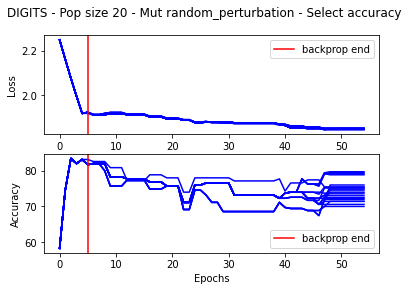

In [119]:
plot_population(best_pop_digits, population_size, mutate_opt, select_opt, 'DIGITS')

### Training and analysing the perfomance on MNIST

In [121]:
## Takes very long to process
model_set_mnist = []

for i in range(population_size):
    model_mnist = Reservoir(input_size_mnist, reservoir_size, n_labels, T, dataset = 'MNIST')
    optimizer_mnist = optim.SGD([p for p in model_mnist.parameters() if p.requires_grad == True], lr=lr_SGD, momentum=momentum_SGD)
    loss_function = nn.NLLLoss(reduction='sum') # Mean is also possible.
    trained_model_mnist = training(model_mnist, train_loader_mnist, val_loader_mnist, n_epochs, optimizer_mnist, loss_function, max_loss_iter)
    model_set_mnist.append(trained_model_mnist)

Training started for 5 epochs.
Epoch: 0 - Loss of: 1.7589003509521484 - Accuracy of: 70.62000274658203
Epoch: 1 - Loss of: 1.4324705039978027 - Accuracy of: 74.94999694824219
Epoch: 2 - Loss of: 1.2285911975860595 - Accuracy of: 77.91000366210938
Epoch: 3 - Loss of: 1.093656999206543 - Accuracy of: 79.5
Epoch: 4 - Loss of: 0.9983034557342529 - Accuracy of: 80.30999755859375
Training started for 5 epochs.
Epoch: 0 - Loss of: 1.8108320953369141 - Accuracy of: 69.52999877929688
Epoch: 1 - Loss of: 1.5001140563964843 - Accuracy of: 74.55000305175781
Epoch: 2 - Loss of: 1.299203367614746 - Accuracy of: 77.62000274658203
Epoch: 3 - Loss of: 1.1628523990631103 - Accuracy of: 78.66000366210938
Epoch: 4 - Loss of: 1.0642255878448486 - Accuracy of: 79.51000213623047
Training started for 5 epochs.
Epoch: 0 - Loss of: 1.7795382972717284 - Accuracy of: 69.97000122070312
Epoch: 1 - Loss of: 1.4692498100280762 - Accuracy of: 74.66999816894531
Epoch: 2 - Loss of: 1.2726515384674073 - Accuracy of: 77.4

In [122]:
# Performing one evolution step, 3rd epoch, only mutation, no selection or recombination yet
ea = EA(population_size, val_loader_mnist, loss_function, input_size_mnist, reservoir_size, n_labels)
    
new_pop = model_set_mnist

# Perform ea steps
for i in range(generations):
    new_pop = ea.step(new_pop, mutate_opt, select_opt)

# Get the best performing population after x amount of generations, based on accuracy or loss
if select_opt == 'accuracy':
    best_pop_mnist = sorted(new_pop, key=lambda k: k['accuracy_results'][-1] , reverse=True) 
elif select_opt == 'loss':
    best_pop_mnist = sorted(new_pop, key=lambda k: k['loss_results'][-1] , reverse=False)


Mutation
Epoch: 5 - Loss of: 1.040530770111084 - Accuracy of: 77.66999816894531
Epoch: 5 - Loss of: 1.1063686344146728 - Accuracy of: 76.37999725341797
Epoch: 5 - Loss of: 1.0733808837890626 - Accuracy of: 78.19999694824219
Epoch: 5 - Loss of: 1.0633760478973389 - Accuracy of: 76.94000244140625
Epoch: 5 - Loss of: 1.0552894241333008 - Accuracy of: 77.01000213623047
Epoch: 5 - Loss of: 1.0707818927764892 - Accuracy of: 76.2699966430664
Epoch: 5 - Loss of: 1.1125454154968262 - Accuracy of: 78.0199966430664
Epoch: 5 - Loss of: 1.0576057006835937 - Accuracy of: 77.87999725341797
Epoch: 5 - Loss of: 1.094732271194458 - Accuracy of: 76.48999786376953
Epoch: 5 - Loss of: 1.0071465629577636 - Accuracy of: 77.52999877929688
Epoch: 5 - Loss of: 1.1400251445770264 - Accuracy of: 75.30999755859375
Epoch: 5 - Loss of: 1.005813736343384 - Accuracy of: 78.80999755859375
Epoch: 5 - Loss of: 1.0534725902557374 - Accuracy of: 78.05999755859375
Epoch: 5 - Loss of: 1.0869421867370606 - Accuracy of: 77.610

Epoch: 10 - Loss of: 1.0666078113555908 - Accuracy of: 76.81999969482422
Epoch: 10 - Loss of: 1.0740968482971192 - Accuracy of: 78.12000274658203
Epoch: 10 - Loss of: 1.0309730224609375 - Accuracy of: 77.52999877929688
Epoch: 10 - Loss of: 1.1126883716583251 - Accuracy of: 74.9800033569336
Epoch: 10 - Loss of: 1.0751338619232178 - Accuracy of: 75.4000015258789
Mutation
Epoch: 11 - Loss of: 1.02733907661438 - Accuracy of: 78.16000366210938
Epoch: 11 - Loss of: 1.0164290893554688 - Accuracy of: 78.12000274658203
Epoch: 11 - Loss of: 1.0651965923309326 - Accuracy of: 79.08999633789062
Epoch: 11 - Loss of: 1.0554325294494629 - Accuracy of: 77.1500015258789
Epoch: 11 - Loss of: 1.0448290744781494 - Accuracy of: 77.2699966430664
Epoch: 11 - Loss of: 1.0219387523651122 - Accuracy of: 78.44999694824219
Epoch: 11 - Loss of: 1.0391189460754395 - Accuracy of: 78.55000305175781
Epoch: 11 - Loss of: 1.0238286922454833 - Accuracy of: 78.2699966430664
Epoch: 11 - Loss of: 1.0796312046051026 - Accurac

Epoch: 16 - Loss of: 1.0491977157592773 - Accuracy of: 77.55000305175781
Epoch: 16 - Loss of: 1.0282269603729248 - Accuracy of: 78.01000213623047
Epoch: 16 - Loss of: 1.047545919418335 - Accuracy of: 79.01000213623047
Epoch: 16 - Loss of: 1.0832161937713622 - Accuracy of: 75.98999786376953
Epoch: 16 - Loss of: 1.093789080429077 - Accuracy of: 76.72000122070312
Epoch: 16 - Loss of: 1.032137620162964 - Accuracy of: 78.37999725341797
Epoch: 16 - Loss of: 1.0389924022674561 - Accuracy of: 78.3499984741211
Epoch: 16 - Loss of: 1.0597859020233154 - Accuracy of: 78.94999694824219
Epoch: 16 - Loss of: 1.0790643737792969 - Accuracy of: 77.37999725341797
Epoch: 16 - Loss of: 1.1068702556610108 - Accuracy of: 76.7699966430664
Epoch: 16 - Loss of: 1.076337755584717 - Accuracy of: 76.95999908447266
Epoch: 16 - Loss of: 1.0855144649505615 - Accuracy of: 76.3499984741211
Mutation
Epoch: 17 - Loss of: 0.9940556491851806 - Accuracy of: 79.47000122070312
Epoch: 17 - Loss of: 0.9936607906341552 - Accurac

Epoch: 22 - Loss of: 0.9910927013397217 - Accuracy of: 78.16999816894531
Epoch: 22 - Loss of: 1.0668476993560791 - Accuracy of: 77.31999969482422
Epoch: 22 - Loss of: 1.044930750274658 - Accuracy of: 78.2699966430664
Epoch: 22 - Loss of: 1.051809970855713 - Accuracy of: 78.72000122070312
Epoch: 22 - Loss of: 1.0247752674102784 - Accuracy of: 78.86000061035156
Epoch: 22 - Loss of: 1.023782459640503 - Accuracy of: 77.95999908447266
Epoch: 22 - Loss of: 1.049780125427246 - Accuracy of: 78.41000366210938
Epoch: 22 - Loss of: 1.0392247173309326 - Accuracy of: 78.5999984741211
Epoch: 22 - Loss of: 1.0250055061340333 - Accuracy of: 77.08000183105469
Epoch: 22 - Loss of: 1.0370602169036864 - Accuracy of: 77.56999969482422
Epoch: 22 - Loss of: 1.0895058292388915 - Accuracy of: 77.81999969482422
Epoch: 22 - Loss of: 1.0778572704315186 - Accuracy of: 77.66999816894531
Epoch: 22 - Loss of: 1.0331341552734374 - Accuracy of: 78.22000122070312
Epoch: 22 - Loss of: 1.0098217544555663 - Accuracy of: 78

Epoch: 27 - Loss of: 1.0055858211517334 - Accuracy of: 80.33000183105469
Epoch: 27 - Loss of: 1.0552060962677001 - Accuracy of: 77.08000183105469
Epoch: 27 - Loss of: 1.078735057067871 - Accuracy of: 77.87999725341797
Epoch: 27 - Loss of: 1.0408755012512207 - Accuracy of: 76.93000030517578
Epoch: 27 - Loss of: 1.0344310192108155 - Accuracy of: 77.0199966430664
Epoch: 27 - Loss of: 1.0961934196472167 - Accuracy of: 78.1500015258789
Mutation
Epoch: 28 - Loss of: 1.0284291103363037 - Accuracy of: 79.08999633789062
Epoch: 28 - Loss of: 1.0216476188659669 - Accuracy of: 79.98999786376953
Epoch: 28 - Loss of: 1.0380551013946533 - Accuracy of: 79.73999786376953
Epoch: 28 - Loss of: 1.1034036849975586 - Accuracy of: 78.11000061035156
Epoch: 28 - Loss of: 1.0727640075683593 - Accuracy of: 77.47000122070312
Epoch: 28 - Loss of: 1.0629779014587402 - Accuracy of: 78.38999938964844
Epoch: 28 - Loss of: 1.0473849548339844 - Accuracy of: 78.76000213623047
Epoch: 28 - Loss of: 1.0630261299133301 - Acc

Epoch: 33 - Loss of: 1.0154376472473146 - Accuracy of: 78.19000244140625
Epoch: 33 - Loss of: 1.040643212890625 - Accuracy of: 78.5199966430664
Epoch: 33 - Loss of: 1.0404351818084716 - Accuracy of: 78.63999938964844
Epoch: 33 - Loss of: 1.0377966976165771 - Accuracy of: 78.0999984741211
Epoch: 33 - Loss of: 1.0364961765289307 - Accuracy of: 78.18000030517578
Epoch: 33 - Loss of: 1.0253310554504393 - Accuracy of: 78.33000183105469
Epoch: 33 - Loss of: 1.035267282485962 - Accuracy of: 78.63999938964844
Epoch: 33 - Loss of: 1.029822601699829 - Accuracy of: 78.33999633789062
Epoch: 33 - Loss of: 1.0637175903320313 - Accuracy of: 78.38999938964844
Epoch: 33 - Loss of: 1.0623831008911133 - Accuracy of: 78.61000061035156
Epoch: 33 - Loss of: 1.0325119426727294 - Accuracy of: 78.5199966430664
Epoch: 33 - Loss of: 1.032761476135254 - Accuracy of: 78.44000244140625
Mutation
Epoch: 34 - Loss of: 1.0463546836853028 - Accuracy of: 78.22000122070312
Epoch: 34 - Loss of: 1.000341915512085 - Accuracy

Epoch: 39 - Loss of: 1.0070297962188721 - Accuracy of: 79.05000305175781
Epoch: 39 - Loss of: 1.0225935276031495 - Accuracy of: 78.02999877929688
Epoch: 39 - Loss of: 1.0556378284454346 - Accuracy of: 78.87999725341797
Epoch: 39 - Loss of: 1.0702846073150636 - Accuracy of: 77.29000091552734
Epoch: 39 - Loss of: 1.0061348049163819 - Accuracy of: 78.51000213623047
Epoch: 39 - Loss of: 1.0951220520019531 - Accuracy of: 77.76000213623047
Epoch: 39 - Loss of: 1.0323283325195312 - Accuracy of: 77.97000122070312
Epoch: 39 - Loss of: 1.0390540664672852 - Accuracy of: 78.19000244140625
Epoch: 39 - Loss of: 1.057938670730591 - Accuracy of: 76.95999908447266
Epoch: 39 - Loss of: 1.0368031757354736 - Accuracy of: 78.05999755859375
Epoch: 39 - Loss of: 1.0480960563659667 - Accuracy of: 78.54000091552734
Epoch: 39 - Loss of: 1.0418145069122315 - Accuracy of: 79.16000366210938
Epoch: 39 - Loss of: 1.0318764053344727 - Accuracy of: 77.8499984741211
Epoch: 39 - Loss of: 1.045009711074829 - Accuracy of:

Epoch: 44 - Loss of: 0.968259326171875 - Accuracy of: 78.9800033569336
Epoch: 44 - Loss of: 1.034316157913208 - Accuracy of: 78.47000122070312
Epoch: 44 - Loss of: 1.0521477592468262 - Accuracy of: 77.91000366210938
Epoch: 44 - Loss of: 1.0645165027618408 - Accuracy of: 78.58999633789062
Epoch: 44 - Loss of: 1.0062440963745116 - Accuracy of: 77.80999755859375
Epoch: 44 - Loss of: 0.9614933544158936 - Accuracy of: 79.29000091552734
Mutation
Epoch: 45 - Loss of: 1.0259778606414796 - Accuracy of: 78.91000366210938
Epoch: 45 - Loss of: 1.0014498756408692 - Accuracy of: 78.41000366210938
Epoch: 45 - Loss of: 1.0090606834411622 - Accuracy of: 78.93000030517578
Epoch: 45 - Loss of: 1.0941886928558349 - Accuracy of: 77.94000244140625
Epoch: 45 - Loss of: 1.0571541175842285 - Accuracy of: 77.37999725341797
Epoch: 45 - Loss of: 1.0016149997711181 - Accuracy of: 77.86000061035156
Epoch: 45 - Loss of: 1.0697374992370605 - Accuracy of: 77.08000183105469
Epoch: 45 - Loss of: 1.0525578792572021 - Acc

Epoch: 50 - Loss of: 1.0136065998077393 - Accuracy of: 80.3499984741211
Epoch: 50 - Loss of: 1.034921955871582 - Accuracy of: 77.13999938964844
Epoch: 50 - Loss of: 1.062130669403076 - Accuracy of: 76.69999694824219
Epoch: 50 - Loss of: 1.0023511608123779 - Accuracy of: 79.44999694824219
Epoch: 50 - Loss of: 1.0391918857574463 - Accuracy of: 79.3499984741211
Epoch: 50 - Loss of: 1.0366580585479737 - Accuracy of: 78.5199966430664
Epoch: 50 - Loss of: 1.0337178825378417 - Accuracy of: 78.16000366210938
Epoch: 50 - Loss of: 1.0482430389404296 - Accuracy of: 78.30999755859375
Epoch: 50 - Loss of: 1.0309325748443603 - Accuracy of: 78.18000030517578
Epoch: 50 - Loss of: 1.0514348712921142 - Accuracy of: 78.80999755859375
Epoch: 50 - Loss of: 1.0941669635772706 - Accuracy of: 75.33000183105469
Epoch: 50 - Loss of: 1.0261661544799805 - Accuracy of: 78.16999816894531
Epoch: 50 - Loss of: 1.042265576171875 - Accuracy of: 78.05999755859375
Mutation
Epoch: 51 - Loss of: 0.9944015377044678 - Accura

In [123]:
# Overview of the structure of the recurrent reservoir. 
print(summary(model_digits, torch.zeros(1, 64), show_input=True, show_hierarchical=False))

-----------------------------------------------------------------------
      Layer (type)         Input Shape         Param #     Tr. Param #
          Linear-1             [1, 64]           8,320               0
            Tanh-2            [1, 128]               0               0
          Linear-3            [1, 128]          16,512               0
          Linear-4             [1, 64]           8,320               0
            ReLU-5            [1, 128]               0               0
          Linear-6            [1, 128]          16,512               0
          Linear-7             [1, 64]           8,320               0
            ReLU-8            [1, 128]               0               0
          Linear-9            [1, 128]          16,512               0
         Linear-10             [1, 64]           8,320               0
           ReLU-11            [1, 128]               0               0
         Linear-12            [1, 128]          16,512               0
     

In [124]:
## Test one model before evolution optim
test_result_mnist = evaluation(test_loader_mnist, trained_model_mnist['model'], 'Final score MNIST', loss_function)

Epoch: Final score MNIST - Loss of: 1.0342742652893067 - Accuracy of: 79.19000244140625


In [127]:
## Test best model after evolution optim. 

test_result_mnist_evo = evaluation(test_loader_mnist, best_pop_mnist[0]['model'], 'Final score MNIST - after evolution', loss_function)

Epoch: Final score MNIST - after evolution - Loss of: 0.9936008407592773 - Accuracy of: 80.01000213623047


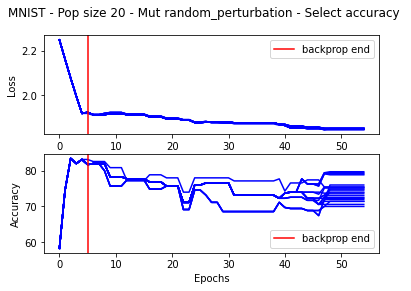

In [128]:
plot_population(best_pop_mnist, population_size, mutate_opt, select_opt, 'MNIST')